In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
print("import done")

Using TensorFlow backend.


import done


In [2]:
#https://github.com/debadridtt/A-Review-of-Different-Word-Embeddings-for-Sentiment-Classification-using-Deep-Learning/blob/master/LSTM%20Experiment.ipynb

In [3]:
DATA_FILE = 'C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/data.csv'
df = pd.read_csv(DATA_FILE,delimiter=';',encoding='UTF-8')
print(df.head())

                                                text     label
0  I had ordered a data cable, got a very well fi...  NOTISSUE
1                                   Love This Phone.  NOTISSUE
2                I get a very well finished product.  NOTISSUE
3                            I could not be happier.  NOTISSUE
4  I was looking for this headset for a long time...  NOTISSUE


In [4]:
df['label'].value_counts() #imbalanced Dataset


NOTISSUE    2030
ISSUE       2025
Name: label, dtype: int64

In [5]:
df.shape

(4055, 2)

In [6]:
msk = np.random.rand(len(df)) < 0.7 # Splitting into train(70%) and test(30%) randomly

In [7]:
train_df=df[msk]
test_df=df[~msk]

In [8]:
print(train_df.shape)
print(test_df.shape)

(2870, 2)
(1185, 2)


In [9]:
print('Checking target values for train data:\n')
print(train_df['label'].value_counts(),'\n')
print('Checking target values for test data:\n')
print(test_df['label'].value_counts())

Checking target values for train data:

NOTISSUE    1439
ISSUE       1431
Name: label, dtype: int64 

Checking target values for test data:

ISSUE       594
NOTISSUE    591
Name: label, dtype: int64


In [10]:
train_df['label'].value_counts()


NOTISSUE    1439
ISSUE       1431
Name: label, dtype: int64

In [11]:
x_train=train_df['text']
y_train=train_df['label']
x_test=test_df['text']
y_test=test_df['label']

### GLOVE EMBEDDING 300

In [12]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [13]:
texts_train = x_train.astype(str)
texts_test = x_test.astype(str)

In [14]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [15]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
test_data = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")

In [16]:
print('Shape of data tensor:', data.shape)
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (2870, 200)
Shape of test_data tensor: (1185, 200)


In [17]:
#import pickle
#file_tok = 'C:/Users/khmar/model_file/LSTM_token_glove_300d_DATA_without_text_processing.sav'
#pickle.dump(tokenizer, open(file_tok, 'wb'))

In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4210 unique tokens.


In [19]:
#pad sequences are used to bring all sentences to same size.
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (2870, 200)
Shape of data test tensor: (1185, 200)


In [20]:
y_train = y_train.map({"NOTISSUE": 1, "ISSUE" : 0 })
y_test = y_test.map({"NOTISSUE": 1, "ISSUE" : 0 })

In [21]:
# load the whole embedding into memory
embeddings_index = {}
f = open('C:/Users/khmar/Desktop/GLOVE/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
#Found 1489 unique tokens : word_index
#print(len(word_index) + 1) #### 1490 
#print(word_index.items()) ### unique tokens : words :word_index
#print('embedding_matrix',embedding_matrix)
out_of_vocab={}
for word, i in word_index.items():
    #print(i)
    embedding_vector = embeddings_index.get(word)
    #print('embedding_vector' ,embedding_vector )
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        #print('word: ', word)
        embedding_matrix[i] = embedding_vector
        #print('embedding_matrix :',embedding_matrix[i] )
        # words not found in embedding index will be all-zeros.
    if embedding_vector is  None:
        #print('word not found :',word)
        out_of_vocab[i] = word
            

In [23]:
f'There are {len(out_of_vocab)} out of vocab '

'There are 252 out of vocab '

In [24]:
model_glove= Sequential()
model_glove.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model_glove.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,input_shape=(1,)))
model_glove.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
model_glove.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
model_glove.fit(data, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(test_data, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2870 samples, validate on 1185 samples
Epoch 1/2
2870/2870 [==============================] - 36s 13ms/step - loss: 0.5633 - acc: 0.7105 - val_loss: 0.5039 - val_acc: 0.7620
Epoch 2/2
2870/2870 [==============================] - 30s 11ms/step - loss: 0.4364 - acc: 0.8098 - val_loss: 0.4411 - val_acc: 0.7949


In [54]:
scores = model_glove.evaluate(x_test, y_test,
                            batch_size=batch_size)
print("%s: %.2f%%" % (model_glove.metrics_names[0], scores[0] * 100))
print("%s: %.2f%%" % (model_glove.metrics_names[1], scores[1] * 100))

1236/1236 [==============================] - 3s 2ms/step
loss: 45.20%
acc: 79.21%


In [36]:
#file_tok = 'C:/Users/khmar/model_file/LSTM_token_glove_300d_DATA.sav'
#pickle.dump(tokenizer, open(file_tok, 'wb'))

In [37]:
# Save the model
#model_glove.save('lstm_model_glove_300_DATA_without_text_processing.sav')

### Prediction

In [111]:
#import pickle
#model_file='lstm_model_glove_300_DATA_without_text_processing.sav'
#token_file='C:/Users/khmar/model_file/LSTM_token_glove_300d_DATA.sav'
#model = pickle.load(open(model_file,'rb'))
#token = pickle.load(open(token_file,'rb'))

#import numpy as np 
#from keras.models import load_model # To save and load model

# Load the model
#my_model = load_model(model_file)
#my_model= model_glove

In [ ]:
def prediction(input_file,output_file,model,token):
    df= pd.DataFrame(columns=['label', 'text'])
    data = pd.read_csv(input_file,delimiter=';')
    inputt=data.text
    x_input = inputt.values
    for i in x_input:
        seq = tokenizer.texts_to_sequences(i)
        seqs = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
        yhat = model_glove.predict(seqs)
        class_pred = model_glove.predict_classes(seqs)
        classe1 = prediction_classe1(class_pred[0])
        df=df.append({'label':classe1,'text':i},ignore_index=True)
    df.to_csv(output_file,sep=';')
    return data,df

In [ ]:
def prediction_classe1(class_pred):
    if class_pred == 1:
        x = 'ISSUE'
    if class_pred== 0:
        x = 'NOTISSUE'
    return x

In [48]:
def prediction_classe(prob):
    x=""
    if prob > 0.5:
          x = 'NOTISSUE'
    if prob <= 0.7:
          x = 'ISSUE'
    return x

In [49]:
#seq= tokenizer.texts_to_sequences("mediocre product")
#seqs = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
#class_pred = model_glove.predict_classes(seqs)
#print(class_pred)
#y = model_glove.predict(seqs)
#print(y)
#classe1 = prediction_classe1(class_pred[0][0])
#print(class_pred[0])
#print(classe1)

In [50]:
## prediction of one word

In [51]:
#token = tokenizer
#seq= token.texts_to_sequences("good service")
#seqs = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
#y = model_glove.predict(seqs)
#class_pred = model_glove.predict_classes(seqs)
#print(prediction_classe(y[0]))

In [84]:
def prediction_classe2(prediction):
    x=""
    if prediction > 0.6:
          x = 'NOTISSUE'
    else :
          x = 'ISSUE'
    return x

In [85]:
text = np.array(['good movie'])
#sequences = tokenizer.texts_to_sequences(text)
#sequences_matrix = pad_sequences(sequences,maxlen=num_max)
seq= tokenizer.texts_to_sequences(text)
sequences_matrix = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
prediction =model_glove.predict(sequences_matrix)
prediction_classe2(prediction)

'NOTISSUE'

In [86]:
### prediction of all data

In [87]:
def prediction2(input_file,output_file):
    df= pd.DataFrame(columns=['label', 'text'])
    data = pd.read_csv(input_file,delimiter=';')
    inputt=data.text
    x_input = inputt.values
    for i in x_input:
        text = np.array(i)
        seq= tokenizer.texts_to_sequences(str(text))
        sequences_matrix = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
        prediction =model_glove.predict(sequences_matrix)
        pred_l=prediction_classe2(prediction[0][0])
        df=df.append({'text':i,'label':pred_l},ignore_index=True)
    df.to_csv(output_file,sep=';')
    return data,df

In [88]:
input_file ='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/data.csv'
output_file ='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/LSTM_pred_glove_300.csv'
prediction2(input_file,output_file)

(                                                   text     label
 0     I had ordered a data cable, got a very well fi...  NOTISSUE
 1                                      Love This Phone.  NOTISSUE
 2                   I get a very well finished product.  NOTISSUE
 3                               I could not be happier.  NOTISSUE
 4     I was looking for this headset for a long time...  NOTISSUE
 5              my headset starts ringing for no reason.     ISSUE
 6     Display is excellent and camera is as good as ...  NOTISSUE
 7                           Battery life is also great!  NOTISSUE
 8     The worst phone I have ever had.... Only had i...     ISSUE
 9     Not a good item.. It worked for a while then s...     ISSUE
 10    This is so embarassing and also my ears hurt i...     ISSUE
 11                     Protects the phone on all sides.  NOTISSUE
 12    This is a VERY average phone with bad battery ...     ISSUE
 13    Clear Skype Calls, Long Battery Life, Long Range.  NOTI

In [89]:
data_predict= pd.read_csv(output_file ,delimiter=';',encoding='latin-1')
print(df.head())

                                                text     label
0  I had ordered a data cable, got a very well fi...  NOTISSUE
1                                   Love This Phone.  NOTISSUE
2                I get a very well finished product.  NOTISSUE
3                            I could not be happier.  NOTISSUE
4  I was looking for this headset for a long time...  NOTISSUE


In [90]:
data_predict['label'].value_counts() #

ISSUE    4055
Name: label, dtype: int64

In [91]:
### confessin matrix

In [92]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df.label,data_predict.label)
print(cm)

[[2025    0]
 [2030    0]]


In [61]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df.label,data_predict.label)
print(cm)

[[1307  718]
 [1290  740]]


In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


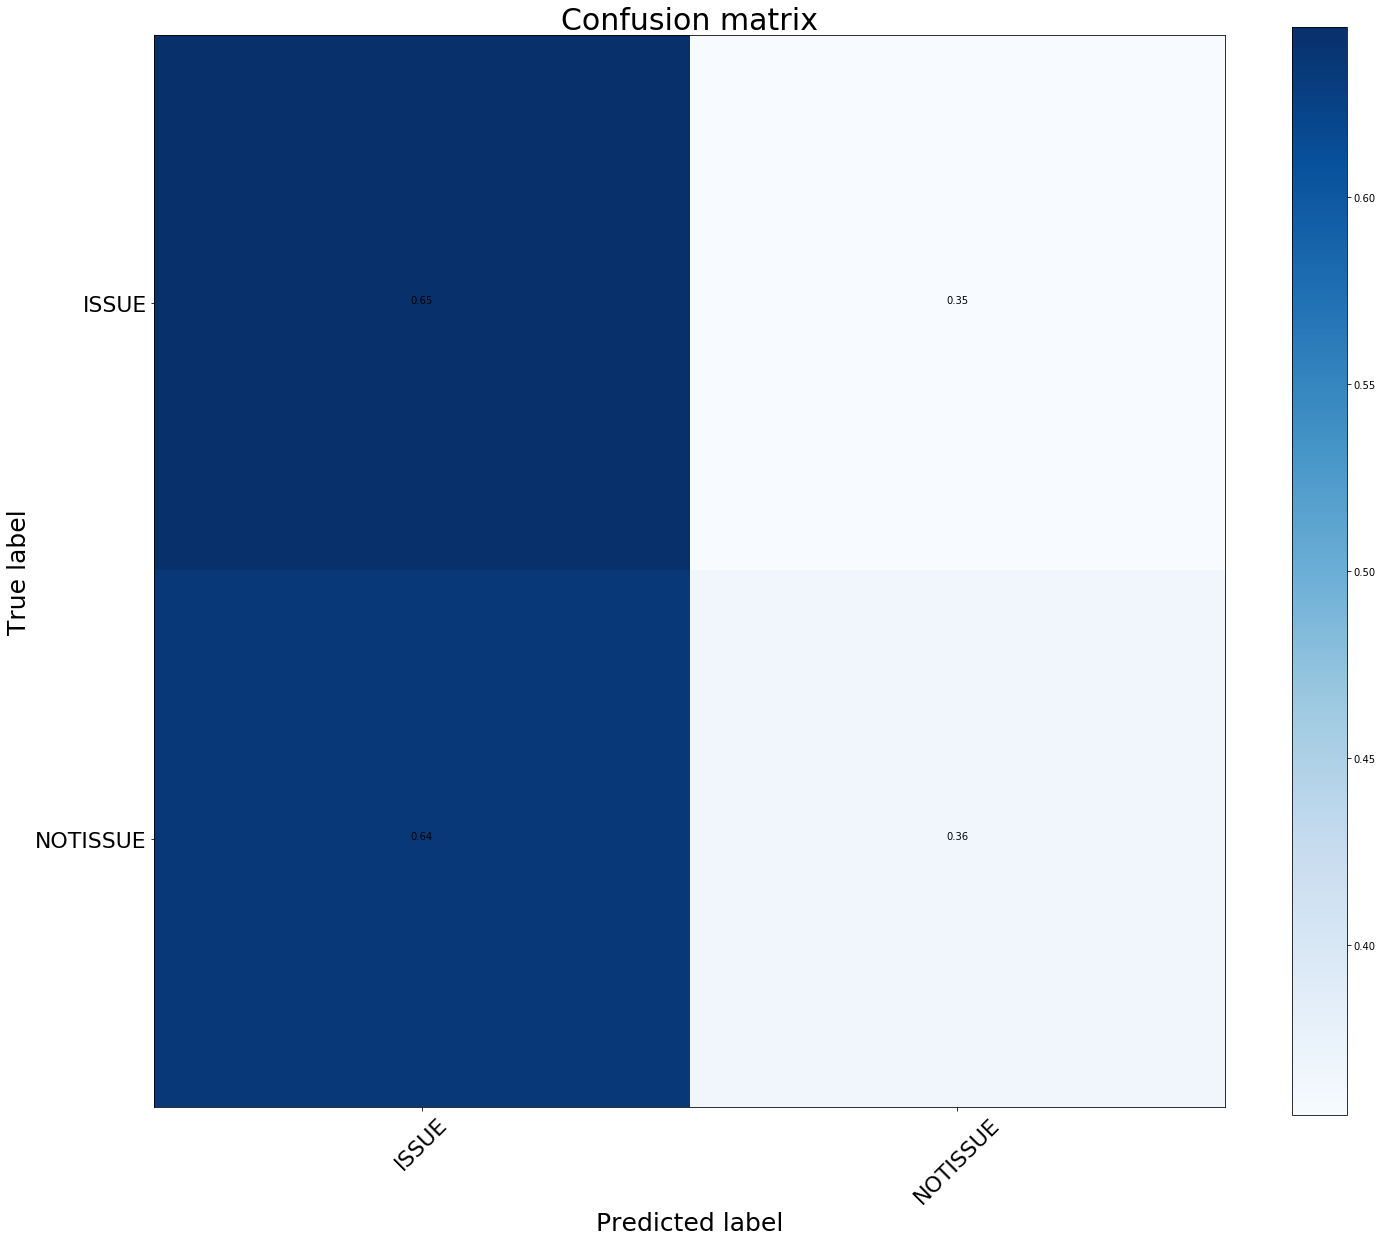

In [65]:
cnf_matrix = confusion_matrix(df.label, data_predict.label)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=['ISSUE','NOTISSUE'], title="Confusion matrix")
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true = df.label, y_pred = data_predict.label)
print(cf)

[[1307  718]
 [1290  740]]


In [68]:
#import json
#print(json.dumps(cf.tolist(), indent=2))

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

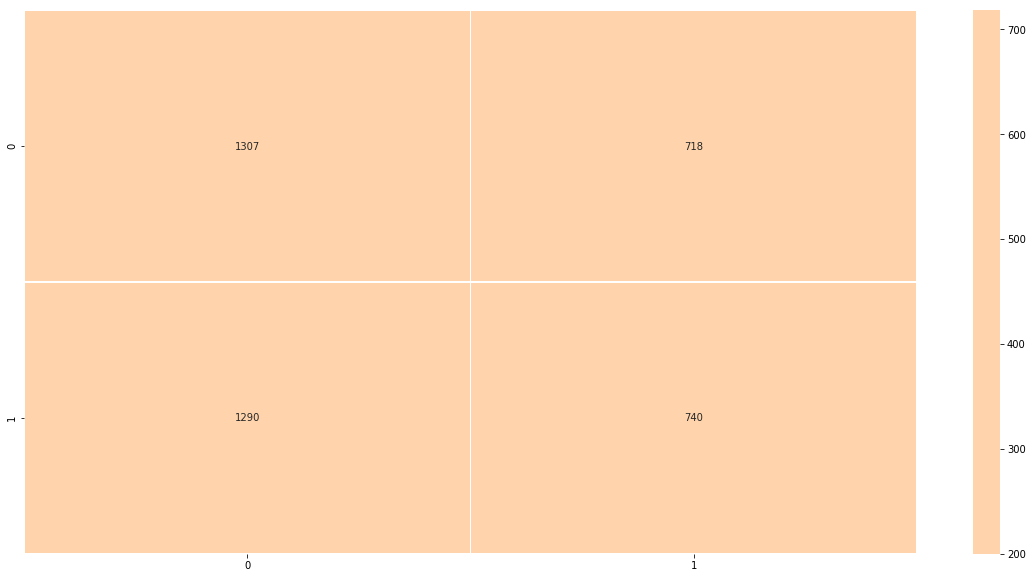

In [76]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(cf, annot=True, fmt="d",linewidths=.5, center = 90, vmax = 200)


In [72]:
def false_pos_neg(input_file,output_file,falses_file):
    diff= pd.DataFrame(columns=['true_label','pred_label', 'Text'])
    data = pd.read_csv(input_file,delimiter=';')
    data_pred = pd.read_csv(output_file,delimiter=';')
    input1 = data.label
    input2 = data_pred.label
    x=data.text.values
    x_input1 = input1.values
    x_input2 = input2.values
    for i in range(len(x_input1)):
        if x_input1[i]!=x_input2[i]:
            diff = diff.append({'true_label':x_input1[i],'pred_label':x_input2[i], 'Text':x[i]},ignore_index=True)
    diff.to_csv(falses_file,sep=';')
    return diff

In [73]:
falses_file='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/false_pred_glove_300.csv'
diff=false_pos_neg(input_file,output_file,falses_file)
print(diff)


     true_label pred_label                                               Text
0      NOTISSUE      ISSUE                                   Love This Phone.
1         ISSUE   NOTISSUE           my headset starts ringing for no reason.
2      NOTISSUE      ISSUE  Display is excellent and camera is as good as ...
3      NOTISSUE      ISSUE                   Protects the phone on all sides.
4      NOTISSUE      ISSUE  Clear Skype Calls, Long Battery Life, Long Range.
5      NOTISSUE      ISSUE                           Great Hands Free Device.
6      NOTISSUE      ISSUE  you can even take self portraits with the outs...
7      NOTISSUE      ISSUE  After trying many many handsfree gadgets this ...
8      NOTISSUE      ISSUE                       The best phone in market :).
9      NOTISSUE      ISSUE  The company shipped my product very promptly a...
10     NOTISSUE      ISSUE                             Exactly what I wanted.
11     NOTISSUE      ISSUE                              This is 

In [74]:
#from sklearn.metrics import confusion_matrix,classification_report
#print('\n*Classification LSTM glove 300:\n', classification_report(y_test, model_glove.prediction2(x_test)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print('accuracy %s' % accuracy_score(data_predict.label, df.label))
print(classification_report(df.label, data_predict.label,target_names=['ISSUE','NOTISSUE']))